In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *


# Initialize logger that adds to text file in current logging folder
from logging_utils import *
init_logger(save_dir=log_dir)
logger = get_logger()

In [2]:
import pathlib
import subprocess
# Get the absolute path to your repository, 
# no matter where you are running this code from

repo_path = os.getcwd() 


git_branch = subprocess.check_output(
    ["git", "-C", repo_path, "rev-parse", "--abbrev-ref", "HEAD"]).strip().decode('UTF-8')

git_commit_short_hash = subprocess.check_output(
    ["git", "-C", repo_path, "describe", "--always"]).strip().decode('UTF-8')


In [3]:
from src_dir import *
import numpy as np

dim=25


x0=np.squeeze(np.zeros((dim,dim)))
x0Type='Zero Solution 2D'

# FD_StencilMat=np.zeros((dim,dim))
# b = np.ones(dim-1)
# c = -2*np.ones(dim)
# np.fill_diagonal(FD_StencilMat[1:], b)
# np.fill_diagonal(FD_StencilMat[:,1:], b)
# np.fill_diagonal(FD_StencilMat, c)
# A=FD_StencilMat
# A=np.asmatrix(A)

A=mk_laplace_2d(dim,dim)
AType='2D Laplacian'

retrain_freq=1
e1 = 1e-3
e2 = 1e-6
nmax_iter = int(dim/5)
restart   = 64

sigma=0.02


DomainL=-1.0
DomainR=1.0

x1=np.linspace(DomainL,DomainR,dim)
x2=np.linspace(DomainL,DomainR,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')

n_steps =2000
InputDim=dim*dim
HiddenDim=dim*dim
OutputDim=dim*dim

In [4]:
# check 2d grid and RHS


import matplotlib.pyplot as pp
from mpl_toolkits.mplot3d import Axes3D


fig = pp.figure()
ax = fig.add_subplot(111, projection='3d')
ProbIdx=200

# Z=np.sin(1)*X+np.cos(1)*Y

xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
Z=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

# Z=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))

ax.plot_surface(X,Y,Z)

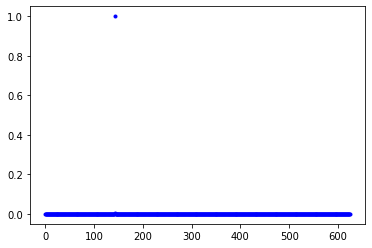

In [5]:
# Check that we flatten according to Fortran ordering(columnwise) 

Z[:,0:5]=0
b_test=np.reshape(Z.T,(1,-1),order='C')
b_norm=np.linalg.norm(b_test)
# print(b_test)
pp.plot((b_test.T)/b_norm,'.b')

In [6]:
# Initial log message
logger.info("Test 2D-Flat problem using 1DConv +1 Conv as FC. Dim 25. Point souce constrained on rose k=6.  ")
#  The source is a narrow gaussian that depends on the integer 'time' in a nonlinear way. The gaussian is on the interval [-5,5], and constrained to move on [-3,3]. ")



# Set up parameter class
class MyParamsClass():
    def __init__(self, AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash):
        self.AType = AType
        self.dim = dim
        self.nmax_iter = nmax_iter
        self.restart = restart
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e1=e1
        self.e2=e2
        self.x0Type=x0Type
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.OutputDim=OutputDim
        self.sigma=sigma
        self.DomainL=DomainL
        self.DomainR=DomainR
        self.git_branch=git_branch
        self.git_commit_short_hash=git_commit_short_hash





import os
import json

params = MyParamsClass(AType,dim,nmax_iter,restart,retrain_freq,e1,e2,x0Type,n_steps,InputDim,HiddenDim,OutputDim,sigma,DomainL,DomainR,git_branch,git_commit_short_hash)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

2020-06-21 01:15:35 [INFO] <ipython-input-6-ab918c2ad954> 2 - Test 2D-Flat problem using 1DConv +1 Conv as FC. Dim 25. Point souce constrained on rose k=6.  


In [7]:
from src_dir import *

# @nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim)
# def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,IterErr0,ProbCount,Add,restart,debug):
#     return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
@cnn_preconditionerOnline_timed_2DFlat(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,OutputDim=OutputDim)
def MLGMRES(A, b,b_flat ,x0,e,nmax_iter,ML_GMRES_Time_list,ProbCount,restart,debug,refine,blist,reslist,Err_list,ML_GMRES_Time_list2):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)



@timer
def GMRES_timed(A, b, x0, e, nmax_iter,restart,debug):
    return GMRES(A, b, x0, e, nmax_iter,restart, debug)

In [8]:
from src_dir import *



ML_GMRES_Time_list=[]
ML_GMRES_Time_list2=[]

Err_list=[]
NonML_Err_List=[]

run_time_ML_list=[]
run_timeP1_ML_list=[]
run_timeP2_ML_list=[]

run_time_list=[]
GmresRunTimeOriginal=[]
GmresRunTimeOriginal2=[]

trainTime_list=[]


debug=True
refine1=False
refine2=True

blist=[]
reslist=[]

eps=0.0001

for ProbIdx in range(n_steps):

    xloc=np.cos(6*ProbIdx)*np.cos(ProbIdx)
    yloc=np.cos(6*ProbIdx)*np.sin(ProbIdx)
    b=Gauss_pdf_2D(X,Y,xloc,yloc,sigma)

#     b=np.maximum(2*X*np.sin(ProbIdx),2*Y*np.cos(ProbIdx))


    b_flat=np.reshape(b.T,(1,-1),order='C').squeeze(0)
    b_norm=np.linalg.norm(b_flat)


    OutList1,run_time1_ML=MLGMRES(A, b/b_norm,b_flat/b_norm ,x0,e1, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine1,blist,reslist,Err_list,ML_GMRES_Time_list2)  # normalize b for optimal NN performance.
    Out=OutList1[0]
    ML_GMRES_Time_list=OutList1[1]
    trainTime_list.append(OutList1[2])
    blist=OutList1[3]
    reslist=OutList1[4]
    Err_list=OutList1[5]

    OutList2,run_time2_ML=MLGMRES(A, b/b_norm,b_flat/b_norm,Out[-1], e2, nmax_iter,ML_GMRES_Time_list,ProbIdx,restart,debug,refine2,blist,reslist,Err_list,ML_GMRES_Time_list2)
    Out2=OutList2[0]
    ML_GMRES_Time_list=OutList2[1]
    trainTime_list.append(OutList2[2])
    blist=OutList2[3]
    reslist=OutList2[4]
    Err_list=OutList2[5]
    ML_GMRES_Time_list2=OutList2[6]

    run_timeP1_ML_list.append(run_time1_ML)
    run_timeP2_ML_list.append(run_time2_ML)
    run_time_ML_list.append(run_time1_ML+run_time2_ML)




    NonML_Out1,run_time1=GMRES_timed(A, b/b_norm, x0, e1, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    NonML_Err=resid(A, NonML_Out1, b/b_norm)
    NonML_Err_List.append(NonML_Err[10])
   
    NonML_Out2,run_time2=GMRES_timed(A, b/b_norm, NonML_Out1[-1], e2, nmax_iter,restart, debug)  # normalize b for optimal NN performance.
    
    GmresRunTimeOriginal.append(run_time1)
    GmresRunTimeOriginal2.append(run_time2)
    run_time_list.append(run_time1+run_time2)

    print(ProbIdx)


run_time=sum(run_time_list)
run_time_ML=sum(run_time_ML_list)
trainTime_total=sum(trainTime_list)

MLGMRES_GMRES_ONLY=sum(ML_GMRES_Time_list2)+sum(ML_GMRES_Time_list)

logger.info("Runtime of Non-decorated version is:")
logger.info(run_time)

logger.info("Runtime of MLGMRES decorator is:")
logger.info(run_time_ML)

logger.info("Runtime of MLGMRES (only GMRES time) is:")
logger.info(MLGMRES_GMRES_ONLY)

logger.info("Runtime of training (backprop) is:")
logger.info(trainTime_total)



0
1
2
3
4
Final loss: 9.769622010935564e-06
parameters 781875
Initial Training
5
size 2
0.5538498336668868 0.6413504155192559
0.8878181499894708 0.5837501186567048 0.8102223931696434 0.5978840140310239
0.8878181499894708 0.5837501186567048 0.8102223931696434 0.5978840140310239
6
size 2
0.46826389310287264 0.8102223931696434
0.4605155370081775 0.6597671264898963 0.569327203427921 0.6509686088156788
0.4605155370081775 0.6597671264898963 0.569327203427921 0.6509686088156788
7
size 2
0.47451783789834057 0.8102223931696434
0.5299904550192878 0.6059838632500032 0.6308350217823985 0.6507779031197859
0.5299904550192878 0.6059838632500032 0.6308350217823985 0.6507779031197859
8
size 2
0.44750229480611103 0.8102223931696434
0.44549510296201333 0.5907851816038601 0.6128859045293518 0.6467893268523084
0.44549510296201333 0.5907851816038601 0.6128859045293518 0.6467893268523084
9
size 2
0.479827666123078 0.8102223931696434
0.5829525099834427 0.579918212199118 0.6328593981899963 0.652924187685714
0.

43
size 2
0.39856102729197795 0.8102223931696434
0.06779387698043138 0.47992728036129845 0.003067033530859553 0.6200920204509447
0.06779387698043138 0.47992728036129845 0.003067033530859553 0.6200920204509447
44
size 2
0.44837214241052853 0.8102223931696434
0.06954039295669645 0.45387454716023057 0.015944686410852366 0.5959855823523381
0.06954039295669645 0.45387454716023057 0.015944686410852366 0.5959855823523381
45
size 2
0.46658667362749073 0.8102223931696434
0.28469309594947845 0.4398016080376692 0.5947668856795064 0.5730395522184696
0.28469309594947845 0.4398016080376692 0.5947668856795064 0.5730395522184696
46
size 2
0.449099675930466 0.8102223931696434
0.20291549898684025 0.4334123669541441 0.49427456534990044 0.5696022497830076
0.20291549898684025 0.4334123669541441 0.49427456534990044 0.5696022497830076
47
size 2
0.44881920003164205 0.8102223931696434
0.2878918730420992 0.4317379514337517 0.5620525097348136 0.5685898629291125
0.2878918730420992 0.4317379514337517 0.56205250973

79
size 2
0.47248456014460327 0.8102223931696434
0.27216794999549165 0.390052366273012 0.2202564528777425 0.5434416962057766
0.27216794999549165 0.390052366273012 0.2202564528777425 0.5434416962057766
80
size 2
0.5357098880520121 0.8102223931696434
0.17979029699927196 0.39014843955170364 0.3336143940731322 0.5304410949314275
0.17979029699927196 0.39014843955170364 0.3336143940731322 0.5304410949314275
81
size 2
0.4506341867713166 0.8102223931696434
0.5668609749991447 0.3857110001519322 0.601744210915235 0.5202859419237669
0.5668609749991447 0.3857110001519322 0.601744210915235 0.5202859419237669
82
size 2
0.4570668287806677 0.8102223931696434
0.44392241502646357 0.3983470427524298 0.5233771632567934 0.5222596007298012
0.44392241502646357 0.3983470427524298 0.5233771632567934 0.5222596007298012
83
size 2
0.4479120360006311 0.8102223931696434
0.3686496299924329 0.39838823791360484 0.5144937674128667 0.5200072172497374
0.3686496299924329 0.39838823791360484 0.5144937674128667 0.5200072172

115
size 2
0.5024987198874474 0.8102223931696434
0.15872380597284064 0.4224413019185886 0.33978022173837197 0.587080999059493
0.15872380597284064 0.4224413019185886 0.33978022173837197 0.587080999059493
116
size 2
0.45119439757485214 0.8102223931696434
0.6767854409990832 0.41280207379721107 0.6069212738752 0.5760030737277696
0.6767854409990832 0.41280207379721107 0.6069212738752 0.5760030737277696
117
size 2
0.44747430192627824 0.8102223931696434
0.40486073499778286 0.4188781847152859 0.5124423105646247 0.57231521471336
0.40486073499778286 0.4188781847152859 0.5124423105646247 0.57231521471336
118
size 2
0.4513727682227791 0.8102223931696434
0.33467910502804443 0.40441431655548515 0.5398728579149029 0.5683042499324592
0.33467910502804443 0.40441431655548515 0.5398728579149029 0.5683042499324592
119
size 2
0.4485936787549086 0.8102223931696434
0.3546040549990721 0.395702890236862 0.5553487048667788 0.5661703227867738
0.3546040549990721 0.395702890236862 0.5553487048667788 0.566170322786

152
size 2
0.4740106567444183 0.8119244341368015
0.38591326802270487 0.3286424228013493 0.6326104956161765 0.49203392157604425
0.38591326802270487 0.3286424228013493 0.6326104956161765 0.49203392157604425
InnerProd [[1.         0.67583444 0.50584745]
 [0.67583444 1.         0.53891732]
 [0.50584745 0.53891732 1.        ]]
retraining
3
Final loss: 6.865111572551541e-06
parameters 781875
153
size 2
0.45390016363140484 0.8119244341368015
0.22221321699908003 0.3286570022418164 0.5982131969772004 0.49964417687608487
0.22221321699908003 0.3286570022418164 0.5982131969772004 0.49964417687608487
154
size 2
0.490939136498954 0.8119244341368015
0.2822756789973937 0.3275988469226286 0.6857593773283658 0.5009523902710188
0.2822756789973937 0.3275988469226286 0.6857593773283658 0.5009523902710188
155
size 2
0.5196228974705 0.8119244341368015
0.2962736070039682 0.32293650752399117 0.7180242727049111 0.5072440588494171
0.2962736070039682 0.32293650752399117 0.7180242727049111 0.5072440588494171
156
s

188
size 2
0.49139256416559646 0.8526303522056996
0.18001794995507225 0.3622657448006794 0.3839612830740797 0.5533501786485914
0.18001794995507225 0.3622657448006794 0.3839612830740797 0.5533501786485914
189
size 2
0.45035994962468 0.8526303522056996
0.4025867589516565 0.34755022995872425 0.4129964784289415 0.5346034158833266
0.4025867589516565 0.34755022995872425 0.4129964784289415 0.5346034158833266
190
size 2
0.5702799930487727 0.8526303522056996
0.5116236270405352 0.3559681961569004 0.7597528190549054 0.5404169504937038
0.5116236270405352 0.3559681961569004 0.7597528190549054 0.5404169504937038
191
size 2
0.5148493536422938 0.8526303522056996
0.34041663497919217 0.36632589731831106 0.5252875754985622 0.5440134339375163
0.34041663497919217 0.36632589731831106 0.5252875754985622 0.5440134339375163
192
size 2
0.4518269818218898 0.8526303522056996
0.5353150209994055 0.37101613875711337 0.6086238321984571 0.5422488502467065
0.5353150209994055 0.37101613875711337 0.6086238321984571 0.542

Final loss: 7.153110800572904e-06
parameters 781875
225
size 2
0.46917774894343306 0.8526303522056996
0.36713475204305723 0.38059036715654654 0.6196373464630968 0.5107313093832926
0.36713475204305723 0.38059036715654654 0.6196373464630968 0.5107313093832926
226
size 2
0.4473455113439274 0.8526303522056996
0.06665686698397622 0.3875715503585525 0.00927419244968839 0.533366740843854
0.06665686698397622 0.3875715503585525 0.00927419244968839 0.533366740843854
227
size 2
0.4957427391643341 0.8526303522056996
0.16184036602498963 0.37848231539828703 0.23888657923824608 0.5104010622061029
0.16184036602498963 0.37848231539828703 0.23888657923824608 0.5104010622061029
228
size 2
0.45193614297038015 0.8526303522056996
0.7168793660239317 0.3564089853595942 0.6148549078213212 0.4947083557998747
0.7168793660239317 0.3564089853595942 0.6148549078213212 0.4947083557998747
229
size 2
0.4530754076662259 0.8526303522056996
0.3372095820377581 0.36355791219975797 0.5665459703579453 0.4954409920294026
0.33

0.40301137004280463 0.3463443396775983 0.5741791462220002 0.4830818683979207
InnerProd [[1.         0.97097512 0.74611442]
 [0.97097512 1.         0.73465974]
 [0.74611442 0.73465974 1.        ]]
retraining
3
Final loss: 9.753601261763833e-06
parameters 781875
263
size 2
0.4782302750214874 0.8526303522056996
0.24948286300059408 0.35345882751746105 0.596687793713613 0.4877220642450801
0.24948286300059408 0.35345882751746105 0.596687793713613 0.4877220642450801
264
size 2
0.4473922013871778 0.8526303522056996
0.12781690602423623 0.3453023643186316 0.026825845246008537 0.4965805298127016
0.12781690602423623 0.3453023643186316 0.026825845246008537 0.4965805298127016
265
size 2
0.45238503370670446 0.8526303522056996
0.20625989197287709 0.33424891939852386 0.555725989198988 0.47416463174879014
0.20625989197287709 0.33424891939852386 0.555725989198988 0.47416463174879014
266
size 2
0.42951097123369397 0.8526303522056996
0.40910726599395275 0.32662303659599273 0.5272795882477302 0.472415458079

0.06674137903610244 0.3579113746411167 0.008362307186170077 0.4872567817600264
298
size 2
0.4482675295992024 0.8526303522056996
0.27348476997576654 0.3405741399223916 0.5270404676240158 0.4676016563608488
0.27348476997576654 0.3405741399223916 0.5270404676240158 0.4676016563608488
299
size 2
0.40022980670883446 0.8526303522056996
0.3777294569881633 0.33447449272265656 0.5638146800190944 0.4606140103644851
0.3777294569881633 0.33447449272265656 0.5638146800190944 0.4606140103644851
300
size 2
0.4477169873577429 0.8526303522056996
0.18254516297020018 0.3316275479225442 0.5787343037379564 0.457449826402848
0.18254516297020018 0.3316275479225442 0.5787343037379564 0.457449826402848
301
size 2
0.50773100225955 0.8526303522056996
0.40321729303104803 0.3369848052016459 0.6874017217566948 0.4797312194838598
0.40321729303104803 0.3369848052016459 0.6874017217566948 0.4797312194838598
302
size 2
0.4851646566328477 0.8526303522056996
0.5920461600180715 0.34486953556071964 0.6057749797938768 0.493

0.04834438598481938 0.31148110824171454 0.005475037472541865 0.38599542139111725
335
size 2
0.46038407085042243 0.8526303522056996
0.5259274449781515 0.30527888556011024 0.5442663454613356 0.3639328789130927
0.5259274449781515 0.30527888556011024 0.5442663454613356 0.3639328789130927
InnerProd [[1.         0.36218716 0.48712591]
 [0.36218716 1.         0.27295458]
 [0.48712591 0.27295458 1.        ]]
retraining
3
Final loss: 9.930367014021613e-06
parameters 781875
336
size 2
0.46921780398978213 0.8526303522056996
0.7122103910078295 0.31724815619876606 0.5125121420021459 0.3819453732831922
0.7122103910078295 0.31724815619876606 0.5125121420021459 0.3819453732831922
337
size 2
0.4578217152851571 0.8526303522056996
0.2720566749922 0.34205158427823334 0.4152876290042592 0.4014700913747156
0.2720566749922 0.34205158427823334 0.4152876290042592 0.4014700913747156
338
size 2
0.4666639583471749 0.8526303522056996
0.22576984600163996 0.34835935091832654 0.49437615509465654 0.4064232874409185
0.

0.3681550539913587 0.34738219015765937 0.565235596347081 0.43122901276244013
InnerProd [[1.         0.69607846 0.60051603]
 [0.69607846 1.         0.82391077]
 [0.60051603 0.82391077 1.        ]]
retraining
2
Final loss: 3.4785469324560836e-05
parameters 781875
371
size 2
0.45757105565304923 0.8526303522056996
0.14602594799362123 0.3486809803172946 0.026070966674198406 0.4348991927877693
0.14602594799362123 0.3486809803172946 0.026070966674198406 0.4348991927877693
372
size 2
0.4681854206149962 0.8526303522056996
0.1551931060384959 0.333057998875156 0.07762249875151078 0.4078912168182233
0.1551931060384959 0.333057998875156 0.07762249875151078 0.4078912168182233
373
size 2
0.4596796551683171 0.8526303522056996
0.2701369969872758 0.32294879303779456 0.5570758352248919 0.3992608752870217
0.2701369969872758 0.32294879303779456 0.5570758352248919 0.3992608752870217
374
size 2
0.4474083101799172 0.8526303522056996
0.32898018998093903 0.3141453434363939 0.269728320858137 0.4028425593371642
0

408
size 2
0.44770908943508186 0.8526303522056996
0.06492711702594534 0.21538047863636167 0.029485588368858732 0.2647046420087985
0.06492711702594534 0.21538047863636167 0.029485588368858732 0.2647046420087985
409
size 2
0.4002642079411874 0.8526303522056996
0.20635097002377734 0.2145802895189263 0.4464834867098896 0.26527419425745186
0.20635097002377734 0.2145802895189263 0.4464834867098896 0.26527419425745186
410
size 2
0.4482679090701 0.8526303522056996
0.33729976502945647 0.21129250367870556 0.5799032409551719 0.27917040444021823
0.33729976502945647 0.21129250367870556 0.5799032409551719 0.27917040444021823
411
size 2
0.45050128931006517 0.8526303522056996
0.26669280300848186 0.21225385691970586 0.2148577951510333 0.2839104648158083
0.26669280300848186 0.21225385691970586 0.2148577951510333 0.2839104648158083
412
size 2
0.44740246820131424 0.8526303522056996
0.20336365897674114 0.20974969387985765 0.050613619018386624 0.2814131383845268
0.20336365897674114 0.20974969387985765 0.050

0.25604131899308413 0.2507690643519163 0.4841933104284562 0.21501265848459297
0.25604131899308413 0.2507690643519163 0.4841933104284562 0.21501265848459297
445
size 2
0.4771655681540745 0.8526303522056996
0.5552975630271249 0.2518728466727771 0.5602151120750899 0.23202015491394248
0.5552975630271249 0.2518728466727771 0.5602151120750899 0.23202015491394248
446
size 2
0.5053779063885565 0.8526303522056996
0.4578304109745659 0.2715082304738462 0.663760618102522 0.2536953488495648
0.4578304109745659 0.2715082304738462 0.663760618102522 0.2536953488495648
InnerProd [[1.         0.4432972  0.30787589]
 [0.4432972  1.         0.5575174 ]
 [0.30787589 0.5575174  1.        ]]
retraining
3
Final loss: 0.0001095257030101493
parameters 781875
447
size 2
0.4642518808942864 0.8526303522056996
0.2094833290320821 0.28886868679430333 0.23859331938766934 0.2800125719083016
0.2094833290320821 0.28886868679430333 0.23859331938766934 0.2800125719083016
448
size 2
0.4495034881441401 0.8526303522056996
0.30

0.11559495801338926 0.2676686822855845 0.10757895511831575 0.28239072734408105
481
size 2
0.49597866771550025 0.8526303522056996
0.8031917770276777 0.25763938976451756 0.5554704861405902 0.2778371901752841
0.8031917770276777 0.25763938976451756 0.5554704861405902 0.2778371901752841
482
size 2
0.4473441597361775 0.8526303522056996
0.316181835019961 0.2769913515658118 0.1708516551347695 0.2771422497066432
0.316181835019961 0.2769913515658118 0.1708516551347695 0.2771422497066432
483
size 2
0.4705099176727271 0.8526303522056996
0.4971171130309813 0.28502487696707246 0.5372453075690942 0.28297853176406845
0.4971171130309813 0.28502487696707246 0.5372453075690942 0.28297853176406845
484
size 2
0.44847391997292513 0.8526303522056996
0.46734063496114686 0.2839283061679453 0.20574908540689488 0.2894709277154259
0.46734063496114686 0.2839283061679453 0.20574908540689488 0.2894709277154259
485
size 2
0.4487018730666097 0.8526303522056996
0.20272082200972363 0.29258136516436933 0.0607121629407585

Final loss: 9.670609870227054e-06
parameters 781875
518
size 2
0.5706882320278197 0.8526303522056996
0.43510518298717216 0.26947826127987357 0.4524519363671955 0.29507124148173447
0.43510518298717216 0.26947826127987357 0.4524519363671955 0.29507124148173447
519
size 2
0.45032967857751544 0.8526303522056996
0.4050549270468764 0.28495045927818863 0.24258369319138307 0.31275205262724115
0.4050549270468764 0.28495045927818863 0.24258369319138307 0.31275205262724115
520
size 2
0.4913910044568103 0.8526303522056996
0.2825369370402768 0.28990806648042056 0.6154344888465668 0.31325966675689143
0.2825369370402768 0.28990806648042056 0.6154344888465668 0.31325966675689143
521
size 2
0.49816895694657115 0.8526303522056996
0.15956300299149007 0.28180421848082915 0.3616833282624424 0.3158025042730028
0.15956300299149007 0.28180421848082915 0.3616833282624424 0.3158025042730028
522
size 2
0.44968169373913863 0.8526303522056996
0.36167045996990055 0.26523119640070947 0.4591305967832868 0.31524528377

555
size 2
0.4539746397536683 0.8526303522056996
0.09775581100257114 0.23119243667460979 0.02129565772653402 0.19841933312638496
0.09775581100257114 0.23119243667460979 0.02129565772653402 0.19841933312638496
556
size 2
0.47332932442042985 0.8526303522056996
0.403382824966684 0.22885566603392363 0.5733056871684653 0.1967693078076233
0.403382824966684 0.22885566603392363 0.5733056871684653 0.1967693078076233
557
size 2
0.5182946112388055 0.8526303522056996
0.28250929998466745 0.23591746163321659 0.20726419806819485 0.21344053037100938
0.28250929998466745 0.23591746163321659 0.20726419806819485 0.21344053037100938
558
size 2
0.44785169453968005 0.8526303522056996
0.0700372889987193 0.23600899387151003 0.011510081770715126 0.2150320677520317
0.0700372889987193 0.23600899387151003 0.011510081770715126 0.2150320677520317
559
size 2
0.5408634924169954 0.8526303522056996
0.2911375609692186 0.23509920299286022 0.07116166561299557 0.2147947078639017
0.2911375609692186 0.23509920299286022 0.0711

Final loss: 0.000491989660076797
parameters 781875
592
size 2
0.45141317140096743 0.8526303522056996
0.3103494389797561 0.22113389191916213 0.175216465963922 0.23413905601210494
0.3103494389797561 0.22113389191916213 0.175216465963922 0.23413905601210494
593
size 2
0.5040577661613835 0.8526303522056996
0.29441306204535067 0.2223848741990514 0.3618911056695609 0.22657108873690468
0.29441306204535067 0.2223848741990514 0.3618911056695609 0.22657108873690468
594
size 2
0.4973373152912477 0.8526303522056996
0.2823041930096224 0.23029716280056164 0.07079066469029581 0.23999013754076412
0.2823041930096224 0.23029716280056164 0.07079066469029581 0.23999013754076412
595
size 2
0.44821861966402765 0.8526303522056996
0.313034318969585 0.24054785148007796 0.18149099732024046 0.24251624936348687
0.313034318969585 0.24054785148007796 0.18149099732024046 0.24251624936348687
596
size 2
0.4473560648783808 0.8526303522056996
0.355161526997108 0.24419619751861318 0.50978995557244 0.2422545534692365
0.35

629
size 2
0.4715094817631084 0.8526303522056996
0.3640501100453548 0.23387387296184897 0.555821486358074 0.24644676310538852
0.3640501100453548 0.23387387296184897 0.555821486358074 0.24644676310538852
630
size 2
0.44736596803422646 0.8526303522056996
0.023546907992567867 0.23937982216244563 0.00313183134104384 0.2512287424769307
0.023546907992567867 0.23937982216244563 0.00313183134104384 0.2512287424769307
631
size 2
0.44965034902698275 0.8526303522056996
0.1824624399887398 0.2115311632421799 0.5479609470245057 0.23459217161239437
0.1824624399887398 0.2115311632421799 0.5479609470245057 0.23459217161239437
632
size 2
0.4128981923944409 0.8526303522056996
0.04354374896502122 0.20897691040299832 0.01956165492360892 0.23487091845260344
0.04354374896502122 0.20897691040299832 0.01956165492360892 0.23487091845260344
633
size 2
0.44793899358578737 0.8526303522056996
0.22370691900141537 0.19954377852147445 0.6420794548465807 0.23019046522536774
0.22370691900141537 0.19954377852147445 0.642

666
size 2
0.449543350935394 0.8526303522056996
0.02377754799090326 0.2048436588025652 0.005054179824850706 0.1966687061605681
0.02377754799090326 0.2048436588025652 0.005054179824850706 0.1966687061605681
667
size 2
0.4746248570969992 0.8526303522056996
0.08348317997297272 0.20240280704339966 0.021136135238415357 0.19570558866672222
0.08348317997297272 0.20240280704339966 0.021136135238415357 0.19570558866672222
668
size 2
0.4478798379967141 0.8526303522056996
0.06382203398970887 0.195098375082016 0.009939297204680779 0.19294303584972877
0.06382203398970887 0.195098375082016 0.009939297204680779 0.19294303584972877
669
size 2
0.4708119451984466 0.8526303522056996
0.22545652999542654 0.19505517676239834 0.06503953856417802 0.1918391680571606
0.22545652999542654 0.19505517676239834 0.06503953856417802 0.1918391680571606
670
size 2
0.4885556694530535 0.8526303522056996
0.3767319229664281 0.20229415684239938 0.4282386322455312 0.19413915233974566
0.3767319229664281 0.20229415684239938 0.4

702
size 2
0.46730269036483935 0.8526303522056996
0.3660430050222203 0.2188114510755986 0.30511835320274155 0.1785279438314922
0.3660430050222203 0.2188114510755986 0.30511835320274155 0.1785279438314922
703
size 2
0.5553528895120217 0.8526303522056996
0.25386929098749533 0.22870350271696224 0.17455764119939543 0.18878216768891812
0.25386929098749533 0.22870350271696224 0.17455764119939543 0.18878216768891812
704
size 2
0.5016984704800862 0.8526303522056996
0.0712713819812052 0.23741447099717333 0.025615607701943127 0.19561927938183224
0.0712713819812052 0.23741447099717333 0.025615607701943127 0.19561927938183224
705
size 2
0.45590471760901563 0.8526303522056996
0.45596341404598206 0.23463073467835785 0.5959940204724078 0.1950122530597868
0.45596341404598206 0.23463073467835785 0.5959940204724078 0.1950122530597868
706
size 2
0.4479339764022426 0.8526303522056996
0.03714260598644614 0.23542455556103958 0.0067279309960488086 0.21583989199530718
0.03714260598644614 0.23542455556103958 0

0.23996087902924046 0.11205767555395141 0.07774875726923876 0.07665647221660138
739
size 2
0.44757151047142507 0.8526303522056996
0.18461246800143272 0.12054181527579204 0.029721092963085675 0.07957472776531353
0.18461246800143272 0.12054181527579204 0.029721092963085675 0.07957472776531353
740
size 2
0.4493687660030363 0.8526303522056996
0.25441059295553714 0.1256660666759126 0.05625513309184267 0.07984356346400508
0.25441059295553714 0.1256660666759126 0.05625513309184267 0.07984356346400508
741
size 2
0.46210036920646563 0.8526303522056996
0.02646133699454367 0.1338689131150022 0.0025068431050484746 0.0816076549155438
0.02646133699454367 0.1338689131150022 0.0025068431050484746 0.0816076549155438
742
size 2
0.3978701674914832 0.8526303522056996
0.03601509996224195 0.12660654195584356 0.02071491626228723 0.06882541988066292
0.03601509996224195 0.12660654195584356 0.02071491626228723 0.06882541988066292
743
size 2
0.4486086265101686 0.8526303522056996
0.025197439012117684 0.1242910112

0.0708978790207766 0.1629022083617747 0.0386207072593919 0.10070721468092794
776
size 2
0.44855100328972236 0.8526303522056996
0.0686899300199002 0.13923615908250211 0.03234458613366077 0.08161757302327904
0.0686899300199002 0.13923615908250211 0.03234458613366077 0.08161757302327904
777
size 2
0.4478054015297662 0.8526303522056996
0.026170405966695398 0.13797794968355448 0.005158998281943706 0.08149051854373329
0.026170405966695398 0.13797794968355448 0.005158998281943706 0.08149051854373329
778
size 2
0.4482061751820022 0.8526303522056996
0.03595915995538235 0.12903537636157125 0.006486492570755579 0.07921216053013343
0.03595915995538235 0.12903537636157125 0.006486492570755579 0.07921216053013343
779
size 2
0.45243583934874615 0.8526303522056996
0.02590478101046756 0.12941525236004964 0.002906535044476775 0.07936077782205421
0.02590478101046756 0.12941525236004964 0.002906535044476775 0.07936077782205421
780
size 2
0.49925375876699435 0.8526303522056996
0.04813689098227769 0.1294202

813
size 2
0.5216503437228186 0.8526303522056996
0.025929254014045 0.128791658799164 0.004644338416377295 0.05780813719715528
0.025929254014045 0.128791658799164 0.004644338416377295 0.05780813719715528
814
size 2
0.4596480301972983 0.8526303522056996
0.025596897990908474 0.1184798280382529 0.007906724491524436 0.048916847977443154
0.025596897990908474 0.1184798280382529 0.007906724491524436 0.048916847977443154
815
size 2
0.5447408461708948 0.8526303522056996
0.23263636196497828 0.11229642659891396 0.10424332194138969 0.04712309309360065
0.23263636196497828 0.11229642659891396 0.10424332194138969 0.04712309309360065
816
size 2
0.4480497948741962 0.8526303522056996
0.4946932750171982 0.10475759463850409 0.5444723342768032 0.040283806658139465
0.4946932750171982 0.10475759463850409 0.5444723342768032 0.040283806658139465
817
size 2
0.5000524945548424 0.8526303522056996
0.2711258049821481 0.12309838959947228 0.24727602052289566 0.06185615061101047
0.2711258049821481 0.12309838959947228 0

0.20301395503338426 0.09731935479678214 0.5395594487571344 0.04465642591724359
InnerProd [[1.         0.29700334 0.49292764]
 [0.29700334 1.         0.35474598]
 [0.49292764 0.35474598 1.        ]]
retraining
3
Final loss: 0.005925065837800503
parameters 781875
851
size 2
0.45261032614531427 0.8526303522056996
0.06445462099509314 0.09910070375772193 0.014889289253245147 0.06121019701051119
0.06445462099509314 0.09910070375772193 0.014889289253245147 0.06121019701051119
852
size 2
0.46327845288856834 0.8526303522056996
0.4490558580146171 0.10073145699920133 0.1476773857510651 0.06150940730814138
0.4490558580146171 0.10073145699920133 0.1476773857510651 0.06150940730814138
853
size 2
0.4884706327835559 0.8526303522056996
0.14463856001384556 0.10619640115881339 0.17734028828169546 0.0647064081335924
0.14463856001384556 0.10619640115881339 0.17734028828169546 0.0647064081335924
854
size 2
0.5163540857659077 0.8526303522056996
0.023506511002779007 0.10941338223870843 0.012588858703640637 0.

0.191145918041002 0.1309539637900889 0.06121397749296894 0.08431952283081323
886
size 2
0.4917622351530931 0.8526303522056996
0.049155468004755676 0.13717347567202523 0.043623485090100646 0.08616711229353013
0.049155468004755676 0.13717347567202523 0.043623485090100646 0.08616711229353013
887
size 2
0.4917029780623049 0.8526303522056996
0.31061821401817724 0.13736532087437808 0.08836801519840277 0.08700171219211082
0.31061821401817724 0.13736532087437808 0.08836801519840277 0.08700171219211082
888
size 2
0.44893182098832374 0.8526303522056996
0.09446539799682796 0.1483670699549839 0.016910028935297465 0.09042752139632128
0.09446539799682796 0.1483670699549839 0.016910028935297465 0.09042752139632128
889
size 2
0.5043156321706345 0.8526303522056996
0.4985342049621977 0.14873966395389288 0.24719439245376432 0.09012782302251666
0.4985342049621977 0.14873966395389288 0.24719439245376432 0.09012782302251666
890
size 2
0.4538986131413096 0.8526303522056996
0.04852847900474444 0.1561525157536

0.03595139499520883 0.12735276959137992 0.022334790504114136 0.06779962623542617
923
size 2
0.4563606901143823 0.8526303522056996
0.026262130006216466 0.12418627247214317 0.004777590098909541 0.06786868554951732
0.026262130006216466 0.12418627247214317 0.004777590098909541 0.06786868554951732
924
size 2
0.4558944035320067 0.8526303522056996
0.12984725600108504 0.11359588859369979 0.0625929935923256 0.061530714701285356
0.12984725600108504 0.11359588859369979 0.0625929935923256 0.061530714701285356
925
size 2
0.44954215148777543 0.8526303522056996
0.225041308964137 0.11772673599421977 0.05945168372204393 0.06376605757588809
0.225041308964137 0.11772673599421977 0.05945168372204393 0.06376605757588809
926
size 2
0.5013200909926465 0.8526303522056996
0.4984981900197454 0.1256899410719052 0.4351713702003288 0.06591128352733398
0.4984981900197454 0.1256899410719052 0.4351713702003288 0.06591128352733398
InnerProd [[1.         0.33091139 0.37130888]
 [0.33091139 1.         0.88464894]
 [0.37

0.026519737963099033 0.12042000368703157 0.0031544524995273868 0.07380723531649996
960
size 2
0.5183161618908085 0.8526303522056996
0.48570284503512084 0.12046216076705604 0.32069297131576974 0.07386364649553723
0.48570284503512084 0.12046216076705604 0.32069297131576974 0.07386364649553723
961
size 2
0.45498581643102404 0.8526303522056996
0.0264180870144628 0.1361636128090322 0.0020044569219034034 0.08599193374298103
0.0264180870144628 0.1361636128090322 0.0020044569219034034 0.08599193374298103
962
size 2
0.44872129789926135 0.8526303522056996
0.22494569700211287 0.1356397382495925 0.049878003156873116 0.08587655235646915
0.22494569700211287 0.1356397382495925 0.049878003156873116 0.08587655235646915
963
size 2
0.44784411017005393 0.8526303522056996
0.026278807956259698 0.13921983152860776 0.003125457047308615 0.08538673297157047
0.026278807956259698 0.13921983152860776 0.003125457047308615 0.08538673297157047
964
size 2
0.4574337096373056 0.8526303522056996
0.06728285696590319 0.139

0.06679712899494916 0.11252589724259451 0.017585887892625825 0.09423768939272481
998
size 2
0.40410467857217075 0.8526303522056996
0.043941494019236416 0.11327166048344224 0.041754370146728455 0.09369649967820863
0.043941494019236416 0.11327166048344224 0.041754370146728455 0.09369649967820863
999
size 2
0.447461294924657 0.8526303522056996
0.02344051405088976 0.10832262016367167 0.005813784304888158 0.0943126986494415
0.02344051405088976 0.10832262016367167 0.005813784304888158 0.0943126986494415
1000
size 2
0.5036547316723453 0.8526303522056996
0.023571964993607253 0.10463679224718363 0.0062569146008395705 0.09336042000102639
0.023571964993607253 0.10463679224718363 0.0062569146008395705 0.09336042000102639
1001
size 2
0.453664479096077 0.8526303522056996
0.02384531096322462 0.09506652208510787 0.004680270190968181 0.08980024859017809
0.02384531096322462 0.09506652208510787 0.004680270190968181 0.08980024859017809
1002
size 2
0.49461037618092235 0.8526303522056996
0.02351379796164110

1034
size 2
0.4475962097814893 0.8526303522056996
0.28525007294956595 0.10089856216916815 0.039473345655501556 0.055384689100235175
0.28525007294956595 0.10089856216916815 0.039473345655501556 0.055384689100235175
1035
size 2
0.44867909853586363 0.8526303522056996
0.02627283800393343 0.11124898776644841 0.0043475572852613165 0.056449582613636806
0.02627283800393343 0.11124898776644841 0.0043475572852613165 0.056449582613636806
1036
size 2
0.44965063908064984 0.8526303522056996
0.22378361196024343 0.11125964200589805 0.12722439149161274 0.056496512194212756
0.22378361196024343 0.11125964200589805 0.12722439149161274 0.056496512194212756
1037
size 2
0.4668208737872301 0.8526303522056996
0.026005922991316766 0.11874922688584774 0.009278594198235252 0.06130301757662839
0.026005922991316766 0.11874922688584774 0.009278594198235252 0.06130301757662839
1038
size 2
0.46505620585490026 0.8526303522056996
0.28258784901117906 0.11875960564473644 0.08060748297867644 0.06148246120432774
0.282587849

1072
size 2
0.4764793020690312 0.8526303522056996
0.036435057991184294 0.09655252739787101 0.007271886165110028 0.06482746524291247
0.036435057991184294 0.09655252739787101 0.007271886165110028 0.06482746524291247
1073
size 2
0.447491177260916 0.8526303522056996
0.06984105100855231 0.08904973919736221 0.038269609715873364 0.06339512953952263
0.06984105100855231 0.08904973919736221 0.038269609715873364 0.06339512953952263
1074
size 2
0.48074586211793974 0.8526303522056996
0.19406339101260528 0.07655242615612223 0.05588359659884619 0.05012731419413944
0.19406339101260528 0.07655242615612223 0.05588359659884619 0.05012731419413944
InnerProd [[1.         0.96997332 0.3650436 ]
 [0.96997332 1.         0.39050776]
 [0.3650436  0.39050776 1.        ]]
retraining
3
Final loss: 0.00258651957847178
parameters 781875
1075
size 2
0.39747430505607845 0.8526303522056996
0.03624904598109424 0.08327859547687694 0.017152827214513465 0.05222812140594068
0.03624904598109424 0.08327859547687694 0.01715282

0.048379915999248624 0.11588121712440624 0.011950570193332396 0.07724750000084747
1109
size 2
0.4483681407594997 1.0277145569314186
0.02584447100525722 0.11513695824425668 0.010668037706299864 0.07733252688220063
0.02584447100525722 0.11513695824425668 0.010668037706299864 0.07733252688220063
1110
size 2
0.4659027985068741 1.0277145569314186
0.0670444979914464 0.11514965744456276 0.016150879581352365 0.07739505130829466
0.0670444979914464 0.11514965744456276 0.016150879581352365 0.07739505130829466
1111
size 2
0.44897069233573794 1.0277145569314186
0.02540086500812322 0.11640033720294013 0.002861214432839017 0.07771031882411798
0.02540086500812322 0.11640033720294013 0.002861214432839017 0.07771031882411798
1112
size 2
0.44869953111807803 1.0277145569314186
0.04640735097927973 0.11638087976258248 0.009491072413501072 0.07730932742345968
0.04640735097927973 0.11638087976258248 0.009491072413501072 0.07730932742345968
1113
size 2
0.4473957389538764 1.0277145569314186
0.20432714803609997 

0.026042249985039234 0.08707643735455349 0.008661086937634415 0.04073311004060688
1146
size 2
0.45065660109870126 1.0277145569314186
0.026166783994995058 0.08707444639410823 0.01133608429552634 0.04074999493426287
0.026166783994995058 0.08707444639410823 0.01133608429552634 0.04074999493426287
1147
size 2
0.45616026195492576 1.0277145569314186
0.06636302400147542 0.08667228847276419 0.010616266447826404 0.040941462305098986
0.06636302400147542 0.08667228847276419 0.010616266447826404 0.040941462305098986
1148
size 2
0.44796170384498074 1.0277145569314186
0.09195022500352934 0.08029876335291192 0.046077549671773854 0.03916737368741224
0.09195022500352934 0.08029876335291192 0.046077549671773854 0.03916737368741224
1149
size 2
0.44965065817350075 1.0277145569314186
0.03622145397821441 0.08027631211094559 0.005169716022609349 0.03880510688844795
0.03622145397821441 0.08027631211094559 0.005169716022609349 0.03880510688844795
1150
size 2
0.4509837374473917 1.0277145569314186
0.204532822011

0.036262695968616754 0.08898498968221247 0.010897469133168039 0.02809013661334882
1182
size 2
0.4474922046981748 1.0277145569314186
0.25013788300566375 0.08939260668121278 0.0666778740565634 0.028284600188052237
0.25013788300566375 0.08939260668121278 0.0666778740565634 0.028284600188052237
1183
size 2
0.4510933365011691 1.0277145569314186
0.09833445202093571 0.09480286128120496 0.024377585368448345 0.028791104718950137
0.09833445202093571 0.09480286128120496 0.024377585368448345 0.028791104718950137
1184
size 2
0.4485501912216705 1.0277145569314186
0.02625355898635462 0.0960386553616263 0.008192795510501833 0.02874584984956812
0.02625355898635462 0.0960386553616263 0.008192795510501833 0.02874584984956812
1185
size 2
0.5383555853425265 1.0277145569314186
0.03649798402329907 0.09425976576050743 0.01158300452859216 0.02835229689945088
0.03649798402329907 0.09425976576050743 0.01158300452859216 0.02835229689945088
1186
size 2
0.47480528005577616 1.0277145569314186
0.0255553990136832 0.09

Final loss: 0.003099658526480198
parameters 781875
1218
size 2
0.45379027486958423 1.0277145569314186
0.09214909799629822 0.12441883412655443 0.04568379288912013 0.051091814323221615
0.09214909799629822 0.12441883412655443 0.04568379288912013 0.051091814323221615
1219
size 2
0.4909650837235953 1.0277145569314186
0.06692620302783325 0.12439382824581116 0.010386184892833886 0.05206329296077135
0.06692620302783325 0.12439382824581116 0.010386184892833886 0.05206329296077135
1220
size 2
0.5192168473266515 1.0277145569314186
0.026074864028487355 0.11199038412654773 0.01307421854912594 0.04800758833373212
0.026074864028487355 0.11199038412654773 0.01307421854912594 0.04800758833373212
1221
size 2
0.46620974693291295 1.0277145569314186
0.03587975702248514 0.10755327440798283 0.0020191589562954574 0.046585087733839556
0.03587975702248514 0.10755327440798283 0.0020191589562954574 0.046585087733839556
1222
size 2
0.4502892031701708 1.0277145569314186
0.0259904739796184 0.10498967264778912 0.0038

0.0358757030335255 0.07222990356618539 0.004477120307500838 0.028750278170834764
1256
size 2
0.51826099616966 1.0277145569314186
0.3793914060224779 0.07222665544832126 0.1964780872237114 0.028751054870612393
0.3793914060224779 0.07222665544832126 0.1964780872237114 0.028751054870612393
InnerProd [[1.         0.80049043 0.69707969]
 [0.80049043 1.         0.82331591]
 [0.69707969 0.82331591 1.        ]]
retraining
2
Final loss: 0.0034368555061519146
parameters 781875
1257
size 2
0.45147047432290816 1.0277145569314186
0.04380368598503992 0.08548089196905494 0.01878907444838987 0.03620266563103028
0.04380368598503992 0.08548089196905494 0.01878907444838987 0.03620266563103028
1258
size 2
0.4702001552003614 1.0277145569314186
0.023881449014879763 0.08578388016670942 0.008049197374712783 0.03649449862416964
0.023881449014879763 0.08578388016670942 0.008049197374712783 0.03649449862416964
1259
size 2
0.46443888065308736 1.0277145569314186
0.12510336196282879 0.08570655456744135 0.05316143335

1291
size 2
0.447348237259285 1.0277145569314186
0.02599260996794328 0.08995178979588672 0.010309301216827126 0.03345520271622138
0.02599260996794328 0.08995178979588672 0.010309301216827126 0.03345520271622138
1292
size 2
0.49537765639959724 1.0277145569314186
0.1257315509719774 0.09005286879604682 0.05863038691457134 0.033791999294964084
0.1257315509719774 0.09005286879604682 0.05863038691457134 0.033791999294964084
1293
size 2
0.45214196088209774 1.0277145569314186
0.026010218949522823 0.08760157019365579 0.001526547404482347 0.027911884141096344
0.026010218949522823 0.08760157019365579 0.001526547404482347 0.027911884141096344
1294
size 2
0.45267802335737306 1.0277145569314186
0.04795924900099635 0.08768156163161621 0.013152400284612136 0.027670431489664034
0.04795924900099635 0.08768156163161621 0.013152400284612136 0.027670431489664034
1295
size 2
0.4476207631767338 1.0277145569314186
0.22422592202201486 0.08306486915098503 0.050030430055756275 0.02637859168572037
0.2242259220220

Final loss: 0.0026623078156262636
parameters 781875
1327
size 2
0.5086728552641119 1.0277145569314186
0.4382045780075714 0.09650966951856389 0.23079059623090534 0.030552700669996834
0.4382045780075714 0.09650966951856389 0.23079059623090534 0.030552700669996834
1328
size 2
0.4798574878323357 1.0277145569314186
0.16068274097051471 0.10489396635908634 0.03161130619070807 0.03754741515662298
0.16068274097051471 0.10489396635908634 0.03161130619070807 0.03754741515662298
1329
size 2
0.44738846397505017 1.0277145569314186
0.1287609840510413 0.11027082511922344 0.0247081054976165 0.03842625148084336
0.1287609840510413 0.11027082511922344 0.0247081054976165 0.03842625148084336
1330
size 2
0.45230763690125364 1.0277145569314186
0.0291933260159567 0.1090494388411753 0.0074760308201395455 0.03746374500323565
0.0291933260159567 0.1090494388411753 0.0074760308201395455 0.03746374500323565
1331
size 2
0.4291041500050667 1.0277145569314186
0.06783016899134964 0.09866558296140283 0.01745583994743379 

0.02368366502923891 0.08771136727882549 0.008950066083116362 0.03290248064087471
1364
size 2
0.40017895719215785 1.0277145569314186
0.024099393049255013 0.08761813623830676 0.019684734260418366 0.03304140332017564
0.024099393049255013 0.08761813623830676 0.019684734260418366 0.03304140332017564
1365
size 2
0.4477292090860028 1.0277145569314186
0.1040791540290229 0.08713572628097609 0.014737666841863778 0.03375632200266898
0.1040791540290229 0.08713572628097609 0.014737666841863778 0.03375632200266898
1366
size 2
0.5085888387222748 1.0277145569314186
0.023469958978239447 0.09024411816382781 0.0026400816148493384 0.03423141250329103
0.023469958978239447 0.09024411816382781 0.0026400816148493384 0.03423141250329103
1367
size 2
0.4828542675701745 1.0277145569314186
0.02354617603123188 0.09013847296359018 0.0030065345093265024 0.03413639086564865
0.02354617603123188 0.09013847296359018 0.0030065345093265024 0.03413639086564865
1368
size 2
0.4920078595166555 1.0277145569314186
0.023457947012

0.043006919033359736 0.08338131963275373 0.019545925730563928 0.020604534120774298
1400
size 2
0.46150940420831965 1.0277145569314186
0.0362038190360181 0.0841583826346323 0.0017306652586014252 0.021091835758866324
0.0362038190360181 0.0841583826346323 0.0017306652586014252 0.021091835758866324
1401
size 2
0.4708381950575938 1.0277145569314186
0.08355870598461479 0.0846759268362075 0.028514925549478987 0.02087305778714407
0.08355870598461479 0.0846759268362075 0.028514925549478987 0.02087305778714407
1402
size 2
0.45821195882001486 1.0277145569314186
0.022984609007835388 0.0870710889948532 0.0059080335591807495 0.021882615786504734
0.022984609007835388 0.0870710889948532 0.0059080335591807495 0.021882615786504734
1403
size 2
0.467266043778741 1.0277145569314186
0.08317227096995339 0.08463350883685053 0.05895208961472693 0.021306990075158082
0.08317227096995339 0.08463350883685053 0.05895208961472693 0.021306990075158082
1404
size 2
0.5001682710300863 1.0277145569314186
0.02314710000064

0.02635817800182849 0.05234411720652133 0.005697776849883102 0.012261554238991198
1436
size 2
0.45720855151382916 1.0277145569314186
0.036387449014000595 0.05247091848636046 0.010834195232935223 0.012408063785876073
0.036387449014000595 0.05247091848636046 0.010834195232935223 0.012408063785876073
1437
size 2
0.46670910334675797 1.0277145569314186
0.07052569603547454 0.04918576000723988 0.018517261534130518 0.011978393781157394
0.07052569603547454 0.04918576000723988 0.018517261534130518 0.011978393781157394
1438
size 2
0.45868843704736095 1.0277145569314186
0.03614190104417503 0.051044131808448585 0.0015516999502454192 0.01259781227710924
0.03614190104417503 0.051044131808448585 0.0015516999502454192 0.01259781227710924
1439
size 2
0.4474154565795871 1.0277145569314186
0.026514609984587878 0.04840166080975905 0.0024189838939334997 0.011046738273484702
0.026514609984587878 0.04840166080975905 0.0024189838939334997 0.011046738273484702
1440
size 2
0.5007608907376586 1.0277145569314186
0

1473
size 2
0.4476976042154514 1.0277145569314186
0.0831707949982956 0.04623060911428183 0.014110872901790866 0.012388095444655632
0.0831707949982956 0.04623060911428183 0.014110872901790866 0.012388095444655632
InnerProd [[1.         0.47580427 0.431475  ]
 [0.47580427 1.         0.22304661]
 [0.431475   0.22304661 1.        ]]
retraining
3
Final loss: 0.0004449265543371439
parameters 781875
1474
size 2
0.40031657349015237 1.0277145569314186
0.026468905969522893 0.04763989083468914 0.009186814598004085 0.012266501305961953
0.026468905969522893 0.04763989083468914 0.009186814598004085 0.012266501305961953
1475
size 2
0.4482686046666779 1.0277145569314186
0.02676296600839123 0.037431847474072126 0.00602699378346122 0.01131703020781516
0.02676296600839123 0.037431847474072126 0.00602699378346122 0.01131703020781516
1476
size 2
0.4503861827571368 1.0277145569314186
0.036604663997422904 0.03581053403439 0.0075719446845166375 0.010819437230617115
0.036604663997422904 0.03581053403439 0.0075

Final loss: 0.0023275127168744802
parameters 781875
1508
size 2
0.45251631329446446 1.0277145569314186
0.026375128014478832 0.0476489466894418 0.0058752840843848755 0.010818763786486975
0.026375128014478832 0.0476489466894418 0.0058752840843848755 0.010818763786486975
1509
size 2
0.44739877740518025 1.0277145569314186
0.025531342020258307 0.047663069169502706 0.0038789534724624894 0.010972141122367648
0.025531342020258307 0.047663069169502706 0.0038789534724624894 0.010972141122367648
1510
size 2
0.47560388690235844 1.0277145569314186
0.02623262704582885 0.04675799217075109 0.008519638004976555 0.010606752912810484
0.02623262704582885 0.04675799217075109 0.008519638004976555 0.010606752912810484
1511
size 2
0.5034388472570946 1.0277145569314186
0.03595264902105555 0.046369539892766626 0.010870889346075129 0.010572981241690904
0.03595264902105555 0.046369539892766626 0.010870889346075129 0.010572981241690904
1512
size 2
0.46488779121948787 1.0277145569314186
0.026541108964011073 0.04586

0.025527516030706465 0.05552692000754177 0.0014624389233325553 0.011847520664414277
1545
size 2
0.4516129502857549 1.0277145569314186
0.025327295006718487 0.0555064608878456 0.009623607334484148 0.011599482597043263
0.025327295006718487 0.0555064608878456 0.009623607334484148 0.011599482597043263
1546
size 2
0.49632085161754746 1.0277145569314186
0.06833316897973418 0.05507568620843813 0.028818554319910428 0.011712612732197931
0.06833316897973418 0.05507568620843813 0.028818554319910428 0.011712612732197931
InnerProd [[1.         0.28592275 0.64345553]
 [0.28592275 1.         0.42324244]
 [0.64345553 0.42324244 1.        ]]
retraining
3
Final loss: 0.001584633020684123
parameters 781875
1547
size 2
0.447342820140963 1.0277145569314186
0.02663334901444614 0.05676600188715383 0.012532923885477701 0.012532890612711654
0.02663334901444614 0.05676600188715383 0.012532923885477701 0.012532890612711654
1548
size 2
0.4726172108013124 1.0277145569314186
0.11603147600544617 0.05677464096806943 0

0.02589164301753044 0.047833909920882434 0.006512505487664252 0.012799093628546934
1581
size 2
0.45250538526297984 1.0277145569314186
0.03608439100207761 0.040751353360246864 0.010933506362609391 0.010923927794696644
0.03608439100207761 0.040751353360246864 0.010933506362609391 0.010923927794696644
1582
size 2
0.5094702253634336 1.0277145569314186
0.026055242982693017 0.04114201660035178 0.01657041797766042 0.010748211662820367
0.026055242982693017 0.04114201660035178 0.01657041797766042 0.010748211662820367
1583
size 2
0.5711928847819819 1.0277145569314186
0.035958566004410386 0.04074102024082094 0.00694086050394904 0.011252998735128993
0.035958566004410386 0.04074102024082094 0.00694086050394904 0.011252998735128993
1584
size 2
0.45028493010461507 1.0277145569314186
0.025840802991297096 0.041136707719415425 0.007517195727902985 0.011182889314048105
0.025840802991297096 0.041136707719415425 0.007517195727902985 0.011182889314048105
1585
size 2
0.4913885234493384 1.0277145569314186
0.0

0.03617571905488148 0.045310063473880294 0.006462323916231069 0.010130146542569727
1617
size 2
0.46867149062022107 1.0277145569314186
0.04808465199312195 0.044850857197307054 0.010435140311163094 0.01006664591396014
0.04808465199312195 0.044850857197307054 0.010435140311163094 0.01006664591396014
1618
size 2
0.5202613398389774 1.0277145569314186
0.03577925497666001 0.04308793027652427 0.010449984080200233 0.009733905574984433
0.03577925497666001 0.04308793027652427 0.010449984080200233 0.009733905574984433
1619
size 2
0.4908939238194018 1.0277145569314186
0.026033549977000803 0.043480872553773225 0.0036581104617769986 0.00991851350242085
0.026033549977000803 0.043480872553773225 0.0036581104617769986 0.00991851350242085
1620
size 2
0.4540882188743723 1.0277145569314186
0.02604864997556433 0.04349692651303485 0.0076293414210412604 0.009856400691358548
0.02604864997556433 0.04349692651303485 0.0076293414210412604 0.009856400691358548
1621
size 2
0.4723451256315266 1.0277145569314186
0.12

0.02397795900469646 0.045107949238736185 0.006389916367056337 0.014816884196715679
1653
size 2
0.5366960738340479 1.0277145569314186
0.02377360500395298 0.045023497878573834 0.007311848382495019 0.015031300766328335
0.02377360500395298 0.045023497878573834 0.007311848382495019 0.015031300766328335
1654
size 2
0.4486739517902266 1.0277145569314186
0.044473977002780885 0.04453469619853422 0.011424825594310963 0.014965373993414964
0.044473977002780885 0.04453469619853422 0.011424825594310963 0.014965373993414964
1655
size 2
0.45188694574267346 1.0277145569314186
0.023900171974673867 0.037278545999433844 0.0010354600804700906 0.012809955213590967
0.023900171974673867 0.037278545999433844 0.0010354600804700906 0.012809955213590967
1656
size 2
0.44744836659117176 1.0277145569314186
0.02373884996632114 0.037306827639695256 0.006611054141863465 0.01264273377898602
0.02373884996632114 0.037306827639695256 0.006611054141863465 0.01264273377898602
1657
size 2
0.4517639413219754 1.0277145569314186

0.026569870009552687 0.05925760060083121 0.006047823725210924 0.014598698666133812
1690
size 2
0.4478374224587674 1.0277145569314186
0.03635544201824814 0.05885285608004778 0.012068319707700358 0.014607386558814873
0.03635544201824814 0.05885285608004778 0.012068319707700358 0.014607386558814873
1691
size 2
0.45879666946889114 1.0277145569314186
0.048921191948466 0.05559188327984885 0.008554351183823404 0.013878374396321343
0.048921191948466 0.05559188327984885 0.008554351183823404 0.013878374396321343
1692
size 2
0.4506242038757219 1.0277145569314186
0.03608565899776295 0.05609814943745732 0.0034137068889504856 0.01390895408623607
0.03608565899776295 0.05609814943745732 0.0034137068889504856 0.01390895408623607
1693
size 2
0.5293686612931723 1.0277145569314186
0.026081677991896868 0.05459347787545994 0.0038822636625801227 0.013414388713288443
0.026081677991896868 0.05459347787545994 0.0038822636625801227 0.013414388713288443
1694
size 2
0.47009633554904057 1.0277145569314186
0.0363219

1726
size 2
0.4490413533009894 1.0277145569314186
0.026441957976203412 0.04416778235929087 0.007945190317412369 0.009613033981447224
0.026441957976203412 0.04416778235929087 0.007945190317412369 0.009613033981447224
1727
size 2
0.4493379472373205 1.0277145569314186
0.02578444400569424 0.04417886939831078 0.007073131195667693 0.009580825798099192
0.02578444400569424 0.04417886939831078 0.007073131195667693 0.009580825798099192
1728
size 2
0.4677809805855153 1.0277145569314186
0.04805704398313537 0.044166502438019964 0.01983296456788723 0.009679220217070277
0.04805704398313537 0.044166502438019964 0.01983296456788723 0.009679220217070277
InnerProd [[1.         0.71525577 0.2417992 ]
 [0.71525577 1.         0.37774185]
 [0.2417992  0.37774185 1.        ]]
retraining
3
Final loss: 0.0007569261360913515
parameters 781875
1729
size 2
0.4483789237061412 1.0277145569314186
0.04838958801701665 0.037962849317118526 0.0101097953040285 0.008695374443986131
0.04838958801701665 0.037962849317118526 

1761
size 2
0.4653660197354541 1.0277145569314186
0.04807247204007581 0.06526221248321235 0.01803670126775756 0.014218794948523607
0.04807247204007581 0.06526221248321235 0.01803670126775756 0.014218794948523607
1762
size 2
0.4499364587801794 1.0277145569314186
0.036092656024266034 0.06525431324495003 0.00943980336384989 0.014336172737893081
0.036092656024266034 0.06525431324495003 0.00943980336384989 0.014336172737893081
1763
size 2
0.39747106539589394 1.0277145569314186
0.026145367010030895 0.06564117944566533 0.020900571288829915 0.014306639922412465
0.026145367010030895 0.06564117944566533 0.020900571288829915 0.014306639922412465
1764
size 2
0.47832567771740464 1.0277145569314186
0.1170274360338226 0.06525468148523941 0.026689775871413465 0.014826449795264134
0.1170274360338226 0.06525468148523941 0.026689775871413465 0.014826449795264134
1765
size 2
0.44752209624839595 1.0277145569314186
0.04862042999593541 0.06888022104511038 0.014084721716805075 0.015817455465656192
0.048620429

0.03580693498952314 0.0422932642349042 0.0091446478581018 0.01128420332033947
1797
size 2
0.4489353680299048 1.0277145569314186
0.04814029601402581 0.04226475927280262 0.009940281683967543 0.011421157649786602
0.04814029601402581 0.04226475927280262 0.009940281683967543 0.011421157649786602
1798
size 2
0.5585065368765312 1.0277145569314186
0.036332866991870105 0.04315575707238167 0.0015024002889972303 0.011732173590586118
0.036332866991870105 0.04315575707238167 0.0015024002889972303 0.011732173590586118
1799
size 2
0.4557225544670204 1.0277145569314186
0.07139847596408799 0.041946590032894165 0.0057903923475717866 0.011496407163667734
0.07139847596408799 0.041946590032894165 0.0057903923475717866 0.011496407163667734
1800
size 2
0.4651275866966962 1.0277145569314186
0.1924390560016036 0.04377477859146893 0.05437311600347922 0.011313753796248388
0.1924390560016036 0.04377477859146893 0.05437311600347922 0.011313753796248388
1801
size 2
0.4709859323674632 1.0277145569314186
0.0261211830

Final loss: 0.0037727560847997665
parameters 781875
1834
size 2
0.4496857783187419 1.0277145569314186
0.027827319980133325 0.05128146972041577 0.006987023990908292 0.011849003800433666
0.027827319980133325 0.05128146972041577 0.006987023990908292 0.011849003800433666
1835
size 2
0.44737658909324696 1.0277145569314186
0.025942470994777977 0.050950813638046384 0.004769630291198013 0.011991689213932268
0.025942470994777977 0.050950813638046384 0.004769630291198013 0.011991689213932268
1836
size 2
0.48919933117988246 1.0277145569314186
0.03624152101110667 0.05005259487777949 0.0038253853328124214 0.01172170781179856
0.03624152101110667 0.05005259487777949 0.0038253853328124214 0.01172170781179856
1837
size 2
0.4522609309626695 1.0277145569314186
0.025848580000456423 0.0478189396392554 0.001208446491544182 0.010131980957531659
0.025848580000456423 0.0478189396392554 0.001208446491544182 0.010131980957531659
1838
size 2
0.5032866101716864 1.0277145569314186
0.03650225099408999 0.047397288519

0.02334821899421513 0.04181576652219519 0.00495098947095973 0.009794076012716807
1871
size 2
0.45464367741836503 1.0277145569314186
0.04289367300225422 0.041287356761749834 0.017104801541798983 0.009656124561505528
0.04289367300225422 0.041287356761749834 0.017104801541798983 0.009656124561505528
InnerProd [[1.         0.36166077 0.62536239]
 [0.36166077 1.         0.56758842]
 [0.62536239 0.56758842 1.        ]]
retraining
3
Final loss: 6.243468669708818e-05
parameters 781875
1872
size 2
0.49999062973563985 1.0277145569314186
0.18023759801872075 0.04197284508263692 0.04223010177969555 0.01006284225002913
0.18023759801872075 0.04197284508263692 0.04223010177969555 0.01006284225002913
1873
size 2
0.4485835323112252 1.0277145569314186
0.025700967002194375 0.045291508443187925 0.010625219946685074 0.010732390090131312
0.025700967002194375 0.045291508443187925 0.010625219946685074 0.010732390090131312
1874
size 2
0.457790875154785 1.0277145569314186
0.036124904989264905 0.04527604076312855

0.0266314729815349 0.04243243796285242 0.00931692594654948 0.010189685892245842
1906
size 2
0.49253081283115413 1.0277145569314186
0.0947734439978376 0.04243411640170962 0.04165708325338001 0.010251472732179223
0.0947734439978376 0.04243411640170962 0.04165708325338001 0.010251472732179223
1907
size 2
0.4831632287660565 1.0277145569314186
0.026325246028136462 0.04431338008027524 0.004902946071915832 0.011571012137997563
0.026325246028136462 0.04431338008027524 0.004902946071915832 0.011571012137997563
1908
size 2
0.48081082427700844 1.0277145569314186
0.04892967903288081 0.04431124792201444 0.016805775404200002 0.011424610024438096
0.04892967903288081 0.04431124792201444 0.016805775404200002 0.011424610024438096
1909
size 2
0.45417020086449256 1.0277145569314186
0.035850198997650295 0.04358723504235968 0.01014711561605947 0.011309612383096189
0.035850198997650295 0.04358723504235968 0.01014711561605947 0.011309612383096189
1910
size 2
0.4999045729433129 1.0277145569314186
0.22892792400

0.02570748602738604 0.045211721481755375 0.004744202863457992 0.013372537483006723
1943
size 2
0.46342554196980834 1.0277145569314186
0.061938470986206084 0.04429872340289876 0.010516804227033645 0.01302770574938438
0.061938470986206084 0.04429872340289876 0.010516804227033645 0.01302770574938438
1944
size 2
0.44815540308021995 1.0277145569314186
0.02579197898739949 0.04572530036326498 0.003942173821456683 0.013306061967449068
0.02579197898739949 0.04572530036326498 0.003942173821456683 0.013306061967449068
1945
size 2
0.4539563882232676 1.0277145569314186
0.0360406159888953 0.041275014721322806 0.007461225014012277 0.011674035681379445
0.0360406159888953 0.041275014721322806 0.007461225014012277 0.011674035681379445
1946
size 2
0.44759450946860746 1.0277145569314186
0.02573899005074054 0.04167390839895233 0.00430203074631556 0.01175482263045023
0.02573899005074054 0.04167390839895233 0.00430203074631556 0.01175482263045023
1947
size 2
0.48386384524212184 1.0277145569314186
0.097759348

0.023885075992438942 0.05246008055983111 0.005722295275142753 0.01907633429526619
1979
size 2
0.5341147379188751 1.0277145569314186
0.08482103201095015 0.052390795920509846 0.03682915262236309 0.01887296833141975
0.08482103201095015 0.052390795920509846 0.03682915262236309 0.01887296833141975
1980
size 2
0.5530312292621151 1.0277145569314186
0.04405955097172409 0.05473965435987339 0.01612978606672601 0.02016823616959375
0.04405955097172409 0.05473965435987339 0.01612978606672601 0.02016823616959375
1981
size 2
0.47596126660372534 1.0277145569314186
0.09784282196778804 0.05280988379847258 0.017909696077375123 0.019984889724728883
0.09784282196778804 0.05280988379847258 0.017909696077375123 0.019984889724728883
1982
size 2
0.4524516402459525 1.0277145569314186
0.06425002199830487 0.054810360397677865 0.021362649119076017 0.020192495091839815
0.06425002199830487 0.054810360397677865 0.021362649119076017 0.020192495091839815
InnerProd [[1.         0.4855664  0.70452812]
 [0.4855664  1.    

2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 87 - Runtime of Non-decorated version is:
2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 88 - 3034.072348332964
2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 90 - Runtime of MLGMRES decorator is:
2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 91 - 2566.084331045102
2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 93 - Runtime of MLGMRES (only GMRES time) is:
2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 94 - 1842.7763655454037
2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 96 - Runtime of training (backprop) is:
2020-06-21 03:06:53 [INFO] <ipython-input-8-7ecf5ee8a18c> 97 - 375.4719047130202


1999


In [9]:
import matplotlib.pyplot as pp
from src_dir import *

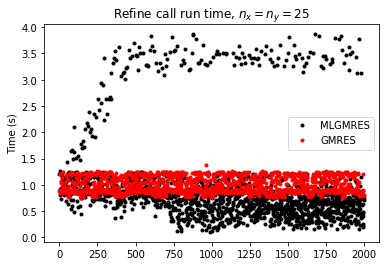

In [10]:
pp.plot(run_timeP2_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r',label='GMRES')
pp.title('Refine call run time, $n_x=n_y=25$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime1.png')

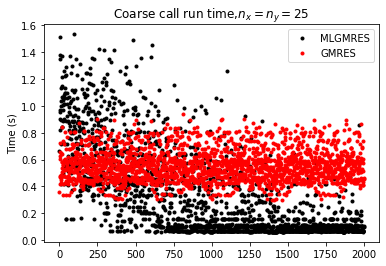

In [11]:
pp.plot(run_timeP1_ML_list,'.k',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r',label='GMRES')
pp.title('Coarse call run time,$n_x=n_y=25$')
pp.ylabel('Time (s)')
pp.legend(loc='best')
pp.savefig('EntireTime2.png')

/home/kl748/Research/NERSC/GMRES-Learning/src_dir/util.py:68: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(a[-Window-1:-1])/Window


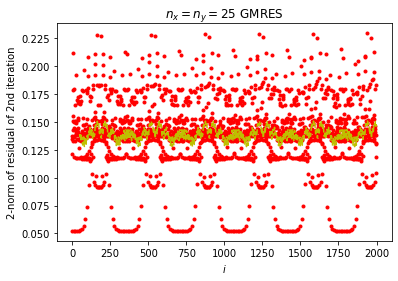

In [12]:
AVG=np.zeros((n_steps,1))
Err_Array=np.asarray(NonML_Err_List)
count=np.arange(0,n_steps)

for j in range(0,n_steps):
    AVG[j]=moving_average(np.asarray(Err_Array[:j]),j)

    
    
pp.plot(count,np.asarray(NonML_Err_List),'.r',count[50:-1],AVG[50:-1],'--y')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=25$ GMRES')
pp.savefig('GMRES.png')

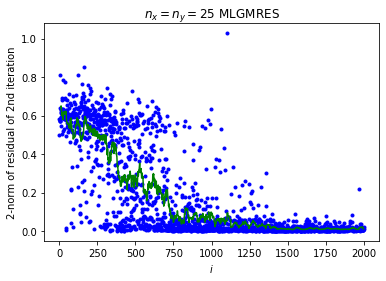

In [13]:
Err_Array_ML=np.asarray(Err_list)
AVGML=np.zeros((n_steps,1))

for j in range(0,n_steps):
    AVGML[j]=moving_average(np.asarray(Err_Array_ML[:j]),j)

pp.plot(count,np.asarray(Err_Array_ML),'.b',count[10:-1],AVGML[10:-1],'g')
pp.xlabel('$i$')
pp.ylabel('2-norm of residual of 2nd iteration')
pp.title('$n_x=n_y=25$ MLGMRES')
pp.savefig('MLGMRES.png')

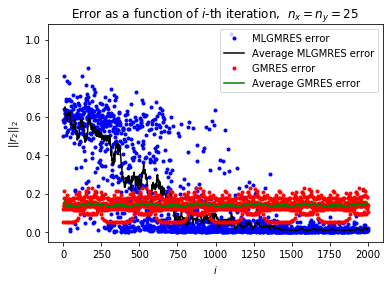

In [14]:
pp.plot(count,Err_Array_ML,'.b',label='MLGMRES error')
pp.plot(count[10:-1],AVGML[10:-1],'k',label='Average MLGMRES error')
pp.plot(count,Err_Array,'.r',label='GMRES error')
pp.plot(count[10:-1],AVG[10:-1],'g',label='Average GMRES error')

pp.xlabel('$i$')
pp.ylabel('$||r_2||_2$')
pp.title('Error as a function of $i$-th iteration,  $n_x=n_y=25$ ')
pp.legend(loc='best')
pp.savefig('Compare.png')

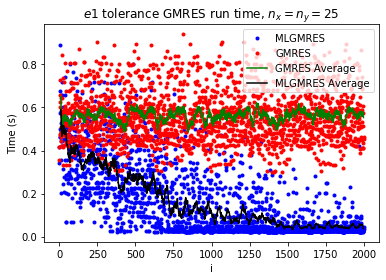

In [15]:
GmresRunTimeOriginal_AVG=np.zeros((n_steps,1))
ML_GMRES_Time_AVG=np.zeros((n_steps,1))


for j in range(0,n_steps):
    GmresRunTimeOriginal_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e1$ tolerance GMRES run time, $n_x=n_y=25$')
pp.legend(loc='best')
pp.savefig('Runtime.png')

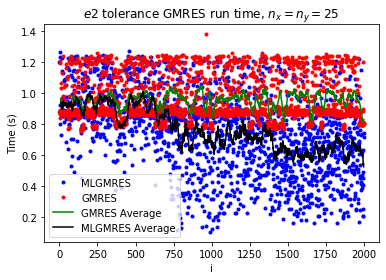

In [16]:
GmresRunTimeOriginal2_AVG=np.zeros((n_steps,1))
ML_GMRES_Time2_AVG=np.zeros((n_steps,1))
count=np.arange(0,n_steps)


for j in range(0,n_steps):
    GmresRunTimeOriginal2_AVG[j]=moving_average(np.asarray(GmresRunTimeOriginal2[:j]),j)

for j in range(0,n_steps):
    ML_GMRES_Time2_AVG[j]=moving_average(np.asarray(ML_GMRES_Time_list2[:j]),j)
    
    
pp.plot(ML_GMRES_Time_list2,'.b',label='MLGMRES')
pp.plot(GmresRunTimeOriginal2,'.r', label='GMRES')
pp.plot(count[10:-1],GmresRunTimeOriginal2_AVG[10:-1],'g', label='GMRES Average')
pp.plot(count[10:-1],ML_GMRES_Time2_AVG[10:-1],'k', label='MLGMRES Average')

pp.ylabel('Time (s)')
pp.xlabel('i')
pp.title('$e2$ tolerance GMRES run time, $n_x=n_y=25$')
pp.legend(loc='best')
pp.savefig('Runtime2.png')

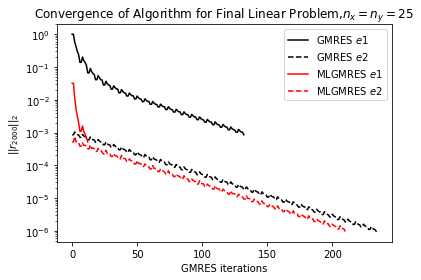

In [17]:
ML_Err=resid(A, Out, b/b_norm)
ML_Err2=resid(A, Out2, b/b_norm)



NonML_Err=resid(A, NonML_Out1, b/b_norm)
NonML_Err2=resid(A, NonML_Out2, b/b_norm)

pp.semilogy(NonML_Err,'k',label='GMRES $e1$')
pp.semilogy(NonML_Err2,'--k',label='GMRES $e2$')
pp.semilogy(ML_Err,'r',label='MLGMRES $e1$')
pp.semilogy(ML_Err2,'--r',label='MLGMRES $e2$')
pp.legend(loc='best')
pp.xlabel('GMRES iterations')
pp.ylabel('$||r_{2000}||_2$')
pp.title('Convergence of Algorithm for Final Linear Problem,$n_x=n_y=25$')
pp.savefig('Error.png')